In [21]:
import commonsetting
from models import perceptual_network, Encoder, Class_out, Conf_out
from dataloader import CustomImageDataset, concatenate_transform_steps
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd


if __name__ == "__main__":
    pretrained_model_name   = commonsetting.pretrained_model_name
    hidden_layer_size       = commonsetting.hidden_layer_size
    hidden_activation_name  = commonsetting.hidden_activation_name
    hidden_activation       = commonsetting.hidden_activation
    hidden_dropout          = commonsetting.hidden_dropout
    resize                  = commonsetting.image_resize
    in_shape                = (1,3,resize,resize)

    SimpleCNN_args = dict(
        pretrained_model_name   = pretrained_model_name,
        hidden_layer_size       = hidden_layer_size,
        hidden_activation       = hidden_activation,
        hidden_dropout          = hidden_dropout,
        hidden_layer_type       = commonsetting.hidden_layer_type,
        output_layer_size       = commonsetting.output_layer_size,
        in_shape                = (1,3,resize,resize),
        retrain_encoder         = commonsetting.retrain_encoder,
        device                  = commonsetting.device,
        )
        

    tranformer_steps = concatenate_transform_steps(image_resize=commonsetting.image_resize, rotate=0)

    dataset_val = CustomImageDataset(commonsetting.test_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_val, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    SimpleCNN = perceptual_network(**SimpleCNN_args)
    SimpleCNN.load_state_dict(torch.load("../models/simplecnn.h5"))
    for p in SimpleCNN.parameters(): p.requires_grad = False
    # define loss function
    classification_loss = nn.BCELoss()
    # when there is no noise
    SimpleCNN.eval()
    SimpleCNN.to(commonsetting.device)
    with torch.no_grad():
        # extract features of each image
        y_true = []
        y_pred = []
        y_correct_pred = []
        confidence_out = []
        for idx_batch, (batch_image, batch_label) in tqdm(enumerate(dataloader_test)):
            batch_label = torch.vstack(batch_label).T.float()
            #记得每一次处理数据之前要做这一步
            
            features,hidden_representation,prediction, confidence =  SimpleCNN(batch_image.to(commonsetting.device))
            correct_preds = batch_label.clone().detach().argmax(1)==prediction.clone().detach().argmax(1)
            correct_preds = correct_preds.float()

            correct_preds = torch.vstack([1-correct_preds, correct_preds]).T.float()
            
            
            y_correct_pred.append(correct_preds.detach().cpu().numpy())
            y_true.append(batch_label.detach().cpu().numpy())
            y_pred.append(prediction.detach().cpu().numpy())
            confidence_out.append(confidence.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_correct_pred = np.concatenate(y_correct_pred, axis=0)
    confidence_out = np.concatenate(confidence_out, axis=0)


12it [00:40,  3.39s/it]


In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [23]:
roc_auc_score(y_true, y_pred)

0.6225

In [24]:
roc_auc_score(y_correct_pred, confidence_out)

0.5948025359926034

In [25]:
y_pred.shape

(360, 3)

In [26]:
from collections import Counter
Counter(y_pred.argmax(1))

Counter({2: 341, 1: 16, 0: 3})

In [27]:
from matplotlib import pyplot as plt

(array([ 5.,  7., 24., 46., 40., 71., 70., 51., 34., 12.]),
 array([0.46612144, 0.49357402, 0.52102661, 0.54847914, 0.57593173,
        0.60338432, 0.6308369 , 0.65828949, 0.68574202, 0.71319461,
        0.7406472 ]),
 <BarContainer object of 10 artists>)

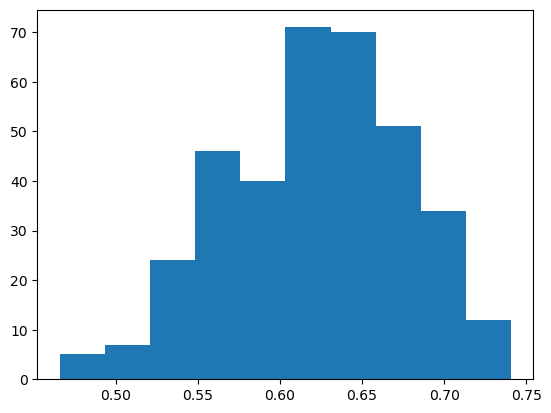

In [43]:
plt.hist(confidence_out[:,0])

In [64]:
confidence_out.argmax(1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [103]:
confidence_onehot = np.vstack([1-confidence_out.argmax(1), confidence_out.argmax(1)]).T

In [104]:
from collections import Counter
Counter(y_correct_pred[:,1])

Counter({1.0: 134, 0.0: 226})

In [105]:
idx_correct_trial = y_correct_pred[:,1] == 1#正确的trial
total_correct = sum(idx_correct_trial.astype(int))

In [106]:
type2_acc = confidence_onehot[:, 1][idx_correct_trial]

In [109]:
len(type2_acc)

134

In [107]:
sum(type2_acc)

3

In [133]:
def type2_correct(confidence, correct_trial):
    confidence_onehot = np.vstack([1-confidence.argmax(1), confidence.argmax(1)]).T
    idx_correct_trial = correct_trial == 1#正确的trial
    total_correct = sum(idx_correct_trial.astype(int))
    type2_acc =confidence_onehot[:, 1][idx_correct_trial]
    return  sum(type2_acc), total_correct

In [134]:
type2_correct(confidence_out, y_correct_pred[:,1])

(3, 134)

In [135]:
3/134

0.022388059701492536